In [1]:
from objects import *
from utils import *

In [5]:
%load_ext autoreload
%autoreload 2
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
import qiskit_metal as metal

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

In [ ]:
filename = "CLT__claw70um_Sabrina_29112023_23.47.07.json"

def run_eigenmode(filename):
    sim_json = open(filename)
    sim_data = json.load(sim_json)
    geometry_dict = sim_data["design_options"]["geometry_dict"]

    cpw_length = int("".join(filter(str.isdigit, geometry_dict["cpw_opts"]["total_length"])))
    claw = create_claw(geometry_dict["claw_opts"], cpw_length, design)
    coupler = create_coupler(geometry_dict["cplr_opts"], design)
    cpw = create_cpw(geometry_dict["cpw_opts"], coupler, design)
    config = SimulationConfig(min_converged_passes=1)

    epra, hfss = start_simulation(design, config)
    setup = set_simulation_hyperparameters(epra, config)
    epra.sim.renderer.options.max_mesh_length_port = '7um'

    render_simulation_with_ports(epra, config.design_name, setup.vars, coupler)
    modeler = hfss.pinfo.design.modeler

    mesh_lengths = {'mesh1': {"objects": [f"prime_cpw_{coupler.name}", f"second_cpw_{coupler.name}", f"trace_{cpw.name}", f"readout_connector_arm_{claw.name}"], "MaxLength": '7um'}}
    #add_ground_strip_and_mesh(modeler, coupler, mesh_lengths=mesh_lengths)
    print(mesh_lengths)
    mesh_objects(modeler, mesh_lengths)
    f_rough, Q, kappa = get_freq_Q_kappa(epra, hfss)

    data = epra.get_data()

    data_df = {
        "design_options": {
            "coupling_type": "CLT",
            "geometry_dict": geometry_dict
        },
        "sim_options": {
            "sim_type": "epr",
            "setup": setup,
        },
        "sim_results": {
            "cavity_frequency": f_rough,
            "Q": Q,
            "kappa": kappa
        },
        "misc": data
    }

    return data_df

emode_df = run_eigenmode(filename)

In [ ]:
from qiskit_metal.analyses.quantization import LOManalysis

def run_LOM(filename):
    c1 = LOManalysis(design, "q3d")

    c1.sim.setup.reuse_selected_design = False
    c1.sim.setup.reuse_setup = False

    # example: update single setting
    c1.sim.setup.max_passes = 30
    c1.sim.setup.min_converged_passes = 1
    c1.sim.setup.percent_error = 0.1
    c1.sim.setup.name = 'sweep_setup'

    sim_json = open(filename)
    sim_data = json.load(sim_json)
    cross_dict = sim_data["design_options"]["geometry_dict"]["claw_opts"]

    # return cross_dict["connection_pads"].keys()

    qname = 'xmon'
    cnames = cross_dict["connection_pads"].keys()
    cname = list(cnames)[0]

    temp_arr = np.repeat(qname, len(cnames))
    ports_zip = zip(temp_arr, cnames)

    # xmon1_options["cross_length"] = f"{cross_length}um"
    # xmon1_options["connection_pads"]["readout"]["claw_length"] = f"{claw_length}um"
    # xmon1_options["connection_pads"]["readout"]["ground_spacing"] = f"{ground_spacing}um"
    # xmon1_options["aedt_hfss_inductance"]=Lj,
    # xmon1_options["hfss_inductance"]=Lj, 
    # xmon1_options["q3d_inductance"]=Lj,
    # xmon1_options["aedt_q3d_inductance"]=Lj
    q = TransmonCross(design, qname, options=cross_dict)
    design.rebuild()
    selection = [qname]
    open_pins = ports_zip #[(qname, cname)]
    print(q.options)
    c1.sim.renderer.clean_active_design()
    c1.sim.run(name = 'LOMv2.0', components=selection,
               open_terminations=open_pins)
    cap_df = c1.sim.capacitance_matrix

    # print(f'For Qubit_{i}, the cap matrix is...')
    print(cap_df)

    data = {
        "design_options": design.components[qname].options,
        "data": {
            "cross_to_ground": 0 if 'ground_main_plane' not in cap_df.loc[f'cross_{qname}'] else cap_df.loc[f'cross_{qname}']['ground_main_plane'],
            "claw_to_ground": 0 if 'ground_main_plane' not in cap_df.loc[f'{cname}_connector_arm_{qname}'] else cap_df.loc[f'{cname}_connector_arm_{qname}']['ground_main_plane'],
            "cross_to_claw": cap_df.loc[f'cross_{qname}'][f'{cname}_connector_arm_{qname}'],
            "cross_to_cross": cap_df.loc[f'cross_{qname}'][f'cross_{qname}'],
            "claw_to_claw": cap_df.loc[f'{cname}_connector_arm_{qname}'][f'{cname}_connector_arm_{qname}'],
            "ground_to_ground": 0 if 'ground_main_plane' not in cap_df.loc[f'cross_{qname}'] else cap_df.loc['ground_main_plane']['ground_main_plane']
        },
        "sim_info": {
            "setup": c1.sim.setup,
            "renderer_options": c1.sim.renderer.options
        }
    }
    # save_simulation_data_to_json(data, filename = f"qubitonly_num{i}_{comp_id}_v{version}")
    return data

lom_df = run_LOM(filename)
lom_df

In [ ]:
def get_sim_results(emode_df, lom_df):
    data_emode = emode_df["sim_results"]
    data_lom = lom_df["data"]

    data = {}

    cross2cpw = abs(lom_df["data"]["cross_to_claw"]) * 1e-15
    cross2ground = abs(lom_df["data"]["cross_to_ground"]) * 1e-15
    f_r = emode_df["sim_results"]["cavity_frequency"]
    Lj = lom_df["design_options"]["aedt_q3d_inductance"] * (1 if lom_df["design_options"]["aedt_q3d_inductance"] > 1e-9 else 1e-9)
    print(Lj)
    gg, aa, ff_q = find_g_a(cross2cpw, cross2ground, f_r, Lj, N=4)
    data = dict(
        f_cavity = f_r,
        Q = emode_df["sim_results"]["Q"],
        kappa = emode_df["sim_results"]["kappa"],
        g = gg,
        a = aa,
        f_qubit = ff_q
    )

    return data

get_sim_results(emode_df, lom_df)

INFO 01:02AM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:02AM [load_ansys_project]: 	Opened Ansys App
INFO 01:02AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:02AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   4p1_xmon_LOM_sweep


Starting the Simulation


INFO 01:02AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d10 [Solution type: Q3D]
INFO 01:02AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:02AM [connect]: 	Connected to project "4p1_xmon_LOM_sweep" and design "LOMv2.0_q3d10" 😀 

INFO 01:02AM [connect_design]: 	Opened active design
	Design:    CavitySweep18 [Solution type: Eigenmode]
WARNING 01:02AM [connect_setup]: 	No design setup detected.
WARNING 01:02AM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:02AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


INFO 01:02AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
{'mesh1': {'objects': ['prime_cpw_cplr', 'second_cpw_cplr', 'trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '7um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project 4p1_xmon_LOM_sweep set to active.


INFO:Global:Project 4p1_xmon_LOM_sweep set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: aedt file load time 0.049001216888427734


INFO:Global:aedt file load time 0.049001216888427734


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 01:04AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:04AM [analyze]: Analyzing setup Setup
01:24AM 59s INFO [get_f_convergence]: Saved convergences to d:\andre\device_simulator\hfss_eig_f_convergence.csv


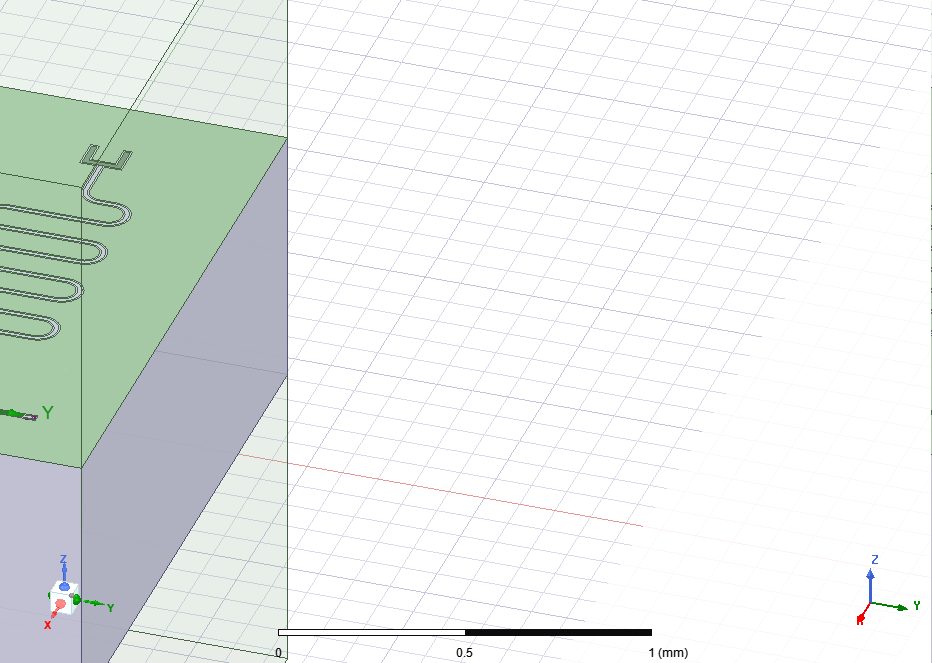

INFO 01:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


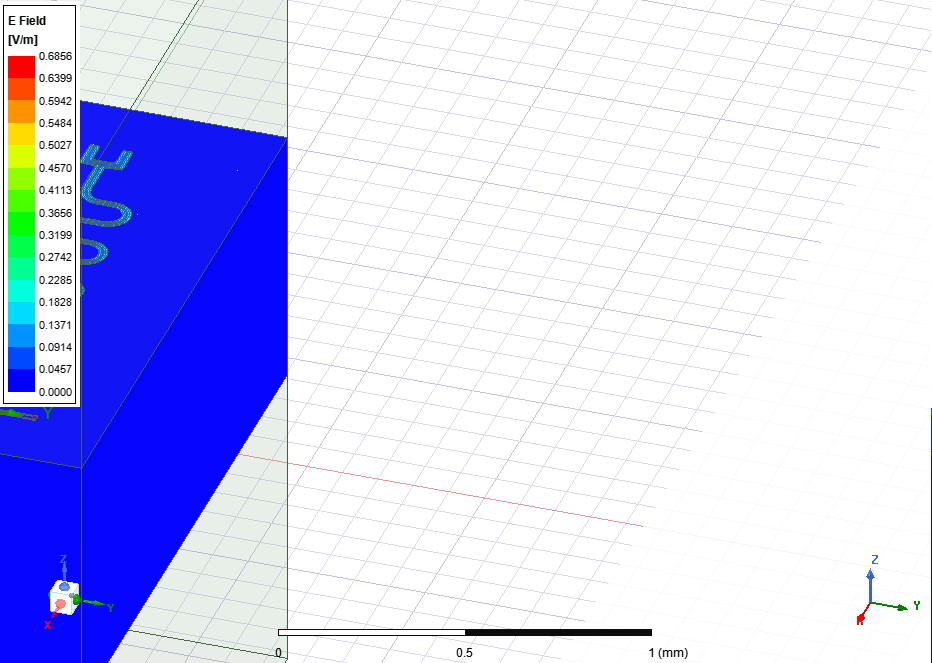

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 6.857 GHz
Q = 49726.0
kappa = 0.138 MHz


INFO 01:25AM [connect_project]: Connecting to Ansys Desktop API...


{'pos_x': '-1500um', 'pos_y': '0.0um', 'orientation': '-90', 'chip': 'main', 'layer': '1', 'connection_pads': {'readout': {'connector_type': '0', 'claw_length': '70um', 'ground_spacing': '4.1um', 'claw_width': '15um', 'claw_gap': '5.1um', 'claw_cpw_length': '0um', 'claw_cpw_width': '11.7um', 'connector_location': '90'}}, 'cross_width': '20um', 'cross_length': '200um', 'cross_gap': '20um', 'hfss_inductance': '10nH', 'hfss_capacitance': 0, 'hfss_resistance': 0, 'hfss_mesh_kw_jj': 7e-06, 'q3d_inductance': '10nH', 'q3d_capacitance': 0, 'q3d_resistance': 0, 'q3d_mesh_kw_jj': 7e-06, 'gds_cell_name': 'my_other_junction', 'aedt_q3d_inductance': 1e-08, 'aedt_q3d_capacitance': 0, 'aedt_hfss_inductance': 1e-08, 'aedt_hfss_capacitance': 0}


INFO 01:25AM [load_ansys_project]: 	Opened Ansys App
INFO 01:25AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:25AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   4p1_xmon_LOM_sweep
INFO 01:26AM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 01:26AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:26AM [connect]: 	Connected to project "4p1_xmon_LOM_sweep" and design "CavitySweep_hfss" 😀 

INFO 01:27AM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d11 [Solution type: Q3D]
WARNING 01:27AM [connect_setup]: 	No design setup detected.
WARNING 01:27AM [connect_setup]: 	Creating Q3D default setup.
INFO 01:27AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


<COMObject GetModule>


INFO 01:27AM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:27AM [analyze]: Analyzing setup sweep_setup
INFO 01:29AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmplpax7d9j.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:29AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpgvy2k7rp.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:29AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpanh6gedv.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:29AM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp0zx5mm2w.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:29AM [get_matrix]: Exporting matrix dat

                            cross_xmon  ground_main_plane  \
cross_xmon                   106.09496         -102.38129   
ground_main_plane           -102.38129          197.55539   
readout_connector_arm_xmon    -2.29489          -45.02253   

                            readout_connector_arm_xmon  
cross_xmon                                    -2.29489  
ground_main_plane                            -45.02253  
readout_connector_arm_xmon                    47.59717  
1e-08


{'f_cavity': 6856862701.13,
 'Q': 49725.97389962597,
 'kappa': 137892.97953160002,
 'g': 34.1123385932909,
 'a': -204.0753936674946,
 'f_qubit': 4.723812390112101}

01:29AM 44s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

01:29AM 45s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [2]:
filename = "CLT__claw70um_Sabrina_29112023_23.47.07.json"


def simulate_single_design(filename):
    emode_df = run_eigenmode(filename)
    lom_df = run_LOM(filename)
    return get_sim_results(emode_df, lom_df)

simulate_single_design(filename=filename)